In [ ]:
%matplotlib inline
import pylab
import numpy as np
import pandas as pd
import scipy.stats
import scipy.sparse
from ggplot import *
import concurrent.futures

In [2]:
#d = np.load('../arrival_time_arrays.npz')
allD = {}
for dataCase in ['indirect_0_830_case0', 'indirect_0_830_case1',
                 'indirect_100_465_case0', 'indirect_100_465_case1',
                 'indirect_466_830_case0', 'indirect_466_830_case1',
                 'indirect_0_465',
                 'directonly_0_465'
                ]:
    d = np.load('../arrays_%s.npz' % dataCase)
    allD[dataCase] = d

In [3]:
for dataCase, d in allD.items():
    print('%s:' %dataCase)
    for f in d.files:
        print('   %s: %s' % (f,np.sum(d[f])))

indirect_100_465_case1:
   indirect_measured: 354437
   direct_simulated: 101673
   direct_measured: 212806
   indirect_simulated: 8719
indirect_100_465_case0:
   indirect_measured: 354437
   direct_simulated: 101694
   direct_measured: 212806
   indirect_simulated: 8589
directonly_0_465:
   indirect_measured: 354437
   direct_simulated: 148330
   direct_measured: 212806
   indirect_simulated: 15927
indirect_0_465:
   indirect_measured: 354437
   direct_simulated: 146993
   direct_measured: 212806
   indirect_simulated: 15172
indirect_466_830_case0:
   indirect_measured: 354437
   direct_simulated: 95728
   direct_measured: 212806
   indirect_simulated: 8540
indirect_466_830_case1:
   indirect_measured: 354437
   direct_simulated: 95212
   direct_measured: 212806
   indirect_simulated: 8559
indirect_0_830_case0:
   indirect_measured: 354437
   direct_simulated: 277474
   direct_measured: 212806
   indirect_simulated: 38818
indirect_0_830_case1:
   indirect_measured: 354437
   direct_si

In [4]:
def softmax(X, theta = 1.0, axis = None):
    """
    Compute the softmax of each element along an axis of X.

    Parameters
    ----------
    X: ND-Array. Probably should be floats. 
    theta (optional): float parameter, used as a multiplier
        prior to exponentiation. Default = 1.0
    axis (optional): axis to compute values along. Default is the 
        first non-singleton axis.

    Returns an array the same size as X. The result will sum to 1
    along the specified axis.
    
    Implementation from: https://nolanbconaway.github.io/blog/2017/softmax-numpy
    """

    # make X at least 2d
    y = np.atleast_2d(X)

    # find axis
    if axis is None:
        axis = next(j[0] for j in enumerate(y.shape) if j[1] > 1)

    # multiply y against the theta parameter, 
    y = y * float(theta)

    # subtract the max for numerical stability
    y = y - np.expand_dims(np.max(y, axis = axis), axis)
    
    # exponentiate y
    y = np.exp(y)

    # take the sum along the specified axis
    ax_sum = np.expand_dims(np.sum(y, axis = axis), axis)

    # finally: divide elementwise
    p = y / ax_sum

    # flatten if X was 1D
    if len(X.shape) == 1: p = p.flatten()

    return p

In [5]:
def bootstrap_test(ma, mb, bootstrap_size=10000, num_samples=1000):
    def bootstrap_samples(ma, mb, bootstrap_size, num_samples):
        aa = ma.flatten()
        ba = mb.flatten()
        
        assert(len(aa)==len(ba))
        
        aprobs = aa.astype(float) / float(sum(aa))
        bprobs = ba.astype(float) / float(sum(ba))

        for sample in range(num_samples):
            aidxs = np.random.choice(len(aa), size=bootstrap_size, replace=True, p=aprobs)
            bidxs = np.random.choice(len(ba), size=bootstrap_size, replace=True, p=bprobs)
            permute_idxs = np.random.randint(0,2,bootstrap_size,dtype=bool)
            #b_permute_idxs = np.random.randint(0,2,bootstrap_size,dtype=bool)

            null_a_s = np.zeros(len(aa), dtype=float)
            null_b_s = np.zeros(len(aa), dtype=float)
            a_s = np.zeros(len(aa), dtype=float)
            b_s = np.zeros(len(aa), dtype=float)

            #test_s = np.zeros(len(aa), dtype=float)
            
            #for i in range(bootstrap_size):
            #    #a_s[aidxs[i]] += 1
            #    #b_s[bidxs[i]] += 1

            #    if a_permute_idxs[i]:
            #        null_a_s[aidxs[i]] += 1
            #    else:
            #        null_a_s[bidxs[i]] += 1

            #    if a_permute_idxs[i]:
            #        null_b_s[bidxs[i]] += 1
            #    else:
            #        null_b_s[aidxs[i]] += 1

            #np.add.at(test_s, aidxs, 1)
            #assert np.all(test_s == a_s), 'substitution does not work'
            
            #np.add.at(test_s, np.where(a_permute_idxs, aidxs, bidxs), 1)
            #assert np.all(test_s == null_a_s), 'substitution does not work'
            
            np.add.at(a_s, aidxs, 1)
            np.add.at(b_s, bidxs, 1)
            np.add.at(null_a_s, np.where(permute_idxs, aidxs, bidxs), 1)
            np.add.at(null_b_s, np.where(permute_idxs, bidxs, aidxs), 1)
            
            yield tuple(x.reshape(ma.shape) for x in [a_s, b_s, null_a_s, null_b_s])
            
    result = []
    for a,b,null_a,null_b in bootstrap_samples(ma, mb, bootstrap_size, num_samples):
        result.append(
            (scipy.stats.entropy(softmax(a).flatten(),softmax(b).flatten()),
             scipy.stats.entropy(softmax(null_a).flatten(),softmax(null_b).flatten())))
    return pd.DataFrame(result, columns=['test','null'])

In [22]:
def bootstrap_test(ma, mb, bootstrap_size=10000, num_samples=1000):
    def bootstrap_samples(ma, mb, bootstrap_size, num_samples):
        aa = ma.flatten()
        ba = mb.flatten()
        
        assert(len(aa)==len(ba))
        
        aprobs = aa.astype(float) / float(sum(aa))
        bprobs = ba.astype(float) / float(sum(ba))

        for sample in range(num_samples):
            aidxs = np.random.choice(len(aa), size=bootstrap_size, replace=True, p=aprobs)
            bidxs = np.random.choice(len(ba), size=bootstrap_size, replace=True, p=bprobs)
            permute_idxs = np.random.randint(0,2,bootstrap_size,dtype=bool)
            #b_permute_idxs = np.random.randint(0,2,bootstrap_size,dtype=bool)

            null_a_s = np.zeros(len(aa), dtype=float)
            null_b_s = np.zeros(len(aa), dtype=float)
            a_s = np.zeros(len(aa), dtype=float)
            b_s = np.zeros(len(aa), dtype=float)

            #test_s = np.zeros(len(aa), dtype=float)
            
            for i in range(bootstrap_size):
                #a_s[aidxs[i]] += 1
                #b_s[bidxs[i]] += 1

                if permute_idxs[i]:
                    null_a_s[aidxs[i]] += 1
                else:
                    null_a_s[bidxs[i]] += 1

                if permute_idxs[i]:
                    null_b_s[bidxs[i]] += 1
                else:
                    null_b_s[aidxs[i]] += 1

            #np.add.at(test_s, aidxs, 1)
            #assert np.all(test_s == a_s), 'substitution does not work'
            
            #np.add.at(test_s, np.where(a_permute_idxs, aidxs, bidxs), 1)
            #assert np.all(test_s == null_a_s), 'substitution does not work'
            
            np.add.at(a_s, aidxs, 1)
            np.add.at(b_s, bidxs, 1)
            #np.add.at(null_a_s, np.where(permute_idxs, aidxs, bidxs), 1)
            #np.add.at(null_b_s, np.where(permute_idxs, bidxs, aidxs), 1)
            
            yield tuple(x.reshape(ma.shape) for x in [a_s, b_s, null_a_s, null_b_s])
            
    result = []
    for a,b,null_a,null_b in bootstrap_samples(ma, mb, bootstrap_size, num_samples):
        result.append(
            (scipy.stats.entropy(softmax(a).flatten(),softmax(b).flatten()),
             scipy.stats.entropy(softmax(null_a).flatten(),softmax(null_b).flatten())))
    return pd.DataFrame(result, columns=['test','null'])

In [29]:
bootstrap_size = 1000
total_samples = 16000
num_workers = 16
samples_per_worker = total_samples // num_workers

In [7]:
futures = []
with concurrent.futures.ProcessPoolExecutor(num_workers) as executor:
    for s in range(0,total_samples,samples_per_worker):
        futures.append(
            executor.submit(
                bootstrap_test,
                d['indirect_measured'], d['indirect_simulated'], bootstrap_size, samples_per_worker))
df_indirect = pd.concat([future.result() for future in futures])

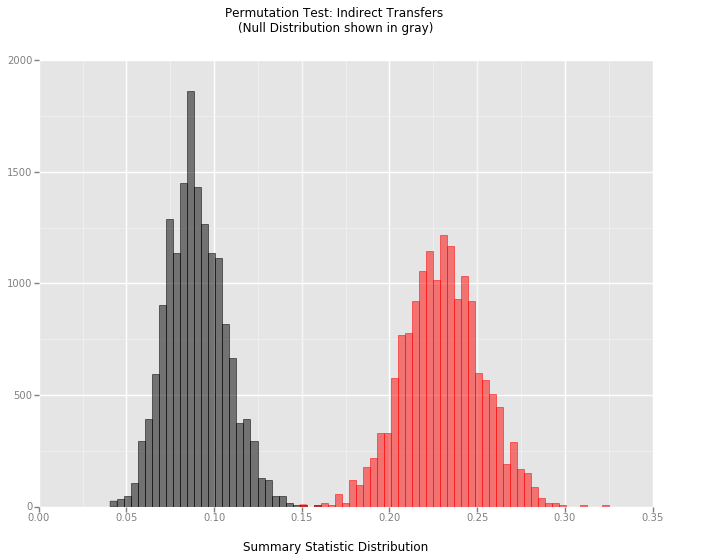

<ggplot: (8775594684725)>

In [8]:
ggplot(df_indirect, aes()) \
    + xlab('Summary Statistic Distribution') \
    + ggtitle('Permutation Test: Indirect Transfers \n(Null Distribution shown in gray)') \
    + geom_histogram(aes(x='null'), fill='black', color='black', alpha=0.5, binwidth=0.004) \
    + geom_histogram(aes(x='test'), fill='red', color='red', alpha=0.5, binwidth=0.004)

In [9]:
futures = []
with concurrent.futures.ProcessPoolExecutor(num_workers) as executor:
    for s in range(0,total_samples,samples_per_worker):
        futures.append(
            executor.submit(
                bootstrap_test,
                d['direct_measured'], d['direct_simulated'], bootstrap_size, samples_per_worker))
df_direct = pd.concat([future.result() for future in futures])

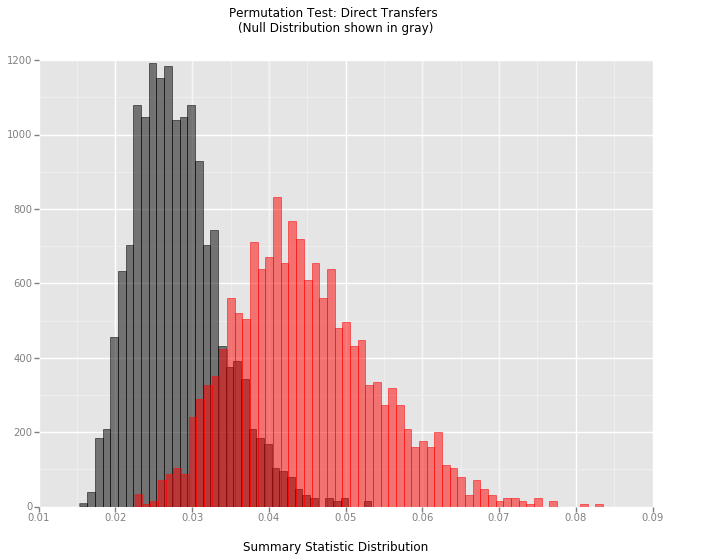

<ggplot: (8775591388045)>

In [10]:
ggplot(df_direct, aes()) \
    + xlab('Summary Statistic Distribution') \
    + ggtitle('Permutation Test: Direct Transfers \n(Null Distribution shown in gray)') \
    + geom_histogram(aes(x='null'), fill='black', color='black', alpha=0.5, binwidth=0.001) \
    + geom_histogram(aes(x='test'), fill='red', color='red', alpha=0.5, binwidth=0.001)

In [30]:
m1 = allD['indirect_466_830_case0']['indirect_simulated']
m2 = allD['indirect_466_830_case0']['indirect_measured']

In [31]:
%%time
futures = []
with concurrent.futures.ProcessPoolExecutor(num_workers) as executor:
    for s in range(0,total_samples,samples_per_worker):
        futures.append(
            executor.submit(
                bootstrap_test,
                m1, m2, bootstrap_size, samples_per_worker))
df_direct = pd.concat([future.result() for future in futures])
print len(df_direct)

16000
CPU times: user 92.2 ms, sys: 209 ms, total: 301 ms
Wall time: 2min 6s


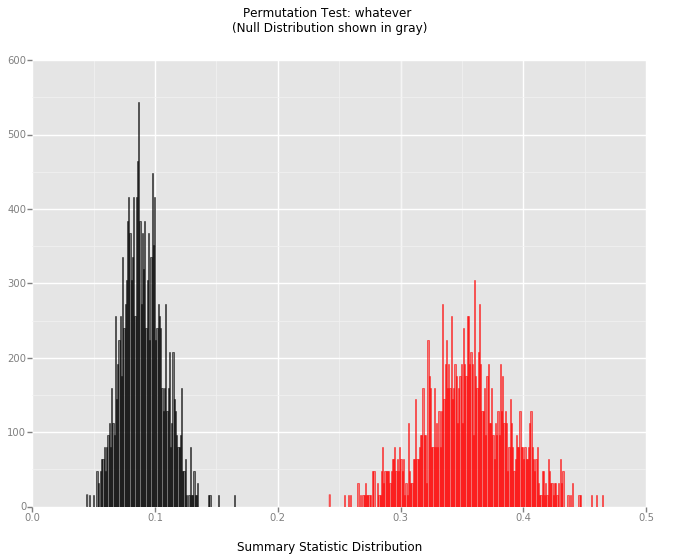

<ggplot: (8775588191425)>

In [32]:
ggplot(df_direct, aes()) \
    + xlab('Summary Statistic Distribution') \
    + ggtitle('Permutation Test: whatever \n(Null Distribution shown in gray)') \
    + geom_histogram(aes(x='null'), fill='black', color='black', alpha=0.5, binwidth=0.001) \
    + geom_histogram(aes(x='test'), fill='red', color='red', alpha=0.5, binwidth=0.001)